In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 29.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 70 kB 8.6 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.1-cp37-cp37m-linux_x86_64.whl size=629484 sha256=b032d8efd6a1bb3c8052155d9d3894691d1b6aeb3014f130758f24b54043a7ec
  Stored in directory: /root/.cache/pip/wheels/17/53/c9/caa05618e686df51f017d8a9923f38d915ce31df67ab6628e6
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=d7f4ae46ed5d6681cf822365dfcb64fd9a9e456c52296b3e3811d45f9a15e55d
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pycuda pytools


In [54]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from time import time

import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/minimum_energy_control')

from kernel_function import KernelFunctions

# Kernel functions

In [12]:
class KernelFunctions:
    def __init__(self):
        pass

    @staticmethod
    def define_MEC_kernel_functions():
        ## block=(TPB,1,1), grid=(axis*step,1,1)
        get_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_gradient(float* matrix, float* vector1, float* vector2, int iteration, float* gradient, int step) {

            __shared__ float result[1000];

            result[tx] = 0.0;

            for (int i = 0; i < iteration; i++) {            
                int index1 = i + tx * iteration;
                int index2 = index1 + bx * 3 * step;

                if (index1 < gs) {
                    result[tx] += matrix[index2] * vector1[index1];
                }
                else {
                    result[1000-tx] = 0.0;
                }
            }

            __syncthreads();

            if (tx == 0) {
                gradient[bx] = 0.0;

                for (int j = 0; j < bs; j++) {
                    gradient[bx] += result[j];
                }

                gradient[bx] -= vector2[bx];
            }
            else {
                result[1000-tx] = 0.0;
            }

            __syncthreads();
        }
        """
        get_gradient_ker = SourceModule(get_gradient_ker_function)

        ## block=(6,1,1), grid=(step,1,1)
        get_G_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_matrix(float* input_matrix, float dt, float* G) {
            // 6: DOF, 18: axis * DOF
            int index = tx + (tx%3) * 6 + bx * 18;

            if (tx < 3) {
                float value;
                value = input_matrix[0] + (step - bx - 1) * dt * input_matrix[1];

                G[index] = value;
            }
            else {
                G[index] = dt;
            }

            __syncthreads();
        }
        """
        get_G_matrix_ker = SourceModule(get_G_matrix_ker_function)

        ## block=(step,1,1), grid=(2,1,1)
        get_Q_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (blockDim.x)

        __global__ void get_Q_matrix(float* gravity, float dt, float* Q) {
            
            __shared__ float value[1000];

            if (bx == 0) {
                value[tx] = gravity[0] + (tx * dt) * gravity[1];
            }
            else {
                value[tx] = gravity[1];
            }

            __syncthreads();

            if (bx == 0) {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[2] += value[i];
                    }
                }
            }
            else {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[5] += value[i];
                    }
                }
            }

            __syncthreads();
        }
        """
        get_Q_matrix_ker = SourceModule(get_Q_matrix_ker_function)

        ## block=(3,1,1), grid=(step,step,1)
        get_G_gram_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define by (blockIdx.y)
        #define step (gridDim.x)

        __global__ void get_G_gram_matrix(float* G, float* rho_matrix, float* gram_G) {
            // 3: axis
            int index1 = 3 * step + 1;
            int index2 = 3 * 3 * step;
            int index3 = tx * index1 + bx * 3 + by * index2;

            // 7: DOF+1, 18: axis*DOF
            int index4 = tx * 7 + bx * 18;
            int index5 = tx * 7 + by * 18;

            float value = 0.0;
            value = G[index4] * G[index5] + G[index4+3] * G[index5+3];

            gram_G[index3] = value;

            __syncthreads();

            gram_G[index3] += rho_matrix[index3] * rho_matrix[index3];

            __syncthreads();
        }
        """
        get_G_gram_matrix_ker = SourceModule(get_G_gram_matrix_ker_function)

        ## block=(3,1,1), grid=(step,1,1)
        get_G_C_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_C_matrix(float* G, float* x_des, float dt, float* x_current, float* Q, float* C, float * G_C) {

            __shared__ float x_A_powered[6];
            __shared__ float C_jerk[6];

            x_A_powered[tx] = x_current[tx] + step * dt * x_current[tx+3];
            x_A_powered[tx+3] = x_current[tx+3];

            __syncthreads();

            C_jerk[tx] = x_des[tx] - Q[tx] - x_A_powered[tx];
            C_jerk[tx+3] = x_des[tx+3] - Q[tx+3] - x_A_powered[tx+3];

            __syncthreads();

            C[tx] = C_jerk[tx];
            C[tx+3] = C_jerk[tx+3];


            __syncthreads();

            // 7: DOF+1, 18: axis*DOF;
            int index1 = tx * 7 + bx * 18;
            int index2 = tx + bx * 3;

            float value;
            value = G[index1] * C_jerk[tx] + G[index1+3] * C_jerk[tx+3];

            __syncthreads();

            G_C[index2] = value;

            __syncthreads();
        }
        """
        get_G_C_matrix_ker = SourceModule(get_G_C_matrix_ker_function)

        for_MEC = dict()
        for_MEC["get_G"]        = get_G_matrix_ker.get_function("get_G_matrix")
        for_MEC["get_Q"]        = get_Q_matrix_ker.get_function("get_Q_matrix")
        for_MEC["get_gram_G"]   = get_G_gram_matrix_ker.get_function("get_G_gram_matrix")
        for_MEC["get_G_C"]      = get_G_C_matrix_ker.get_function("get_G_C_matrix")
        for_MEC["get_gradient"] = get_gradient_ker.get_function("get_gradient")

        return for_MEC

################################################################################

    @staticmethod
    def define_optimizer_kernel_functions():
        ## block=(3,1,1), grid=(step,1,1)
        basic_optimizer_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void basic_optimizer(float* theta, float* gradient, float learning_rate) {

            int index = tx + bx * 3;

            theta[index] -= gradient[index] * learning_rate;

            __syncthreads();
        }
        """
        basic_optimizer_ker = SourceModule(basic_optimizer_ker_function)
        
        for_optimizer = dict()
        for_optimizer["basic_optimizer"] = basic_optimizer_ker.get_function("basic_optimizer")

        return for_optimizer

################################################################################

    @staticmethod
    def define_evaluator_kernel_functions():
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {
            
            if (bx < 6) {
                __shared__ float value[1000];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i <iteration; i++) {
                    int index1 = i + tx * iteration;
                    int index2 = index1 * 6 + bx;

                    value[tx] += G[index2] * u[index1];
                }

                __syncthreads();

                if (tx == 0) {
                    value[1000] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[1000] += value[j];
                    }

                    error_vector[bx] = value[1000] - C[bx];
                }
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_vector_norm_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_vector_norm(float* vector, float* vector_norm) {

            __shared__ float value[1000];

            int index1 = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index1+i] = vector[index1+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs * 3;

                vector_norm[0] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_vector_norm_ker = SourceModule(get_vector_norm_ker_function)

        ## block=(step,1,1), grid=(1,1,1)
        get_norm_of_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_norm_of_gradient(float* gradient, float* norm_of_gradient) {

            __shared__ float value[1000];

            int index1 = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index1+i] = gradient[index1+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs * 3;

                norm_of_gradient[0] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_norm_of_gradient_ker = SourceModule(get_norm_of_gradient_ker_function)

        for_evaluator = dict()
        for_evaluator["get_error_vector"]     = get_error_vector_ker.get_function("get_error_vector")
        for_evaluator["get_vector_norm"]      = get_vector_norm_ker.get_function("get_vector_norm")
        for_evaluator["get_norm_of_gradient"] = get_norm_of_gradient_ker.get_function("get_norm_of_gradient")

        return for_evaluator

################################################################################

    @staticmethod
    def define_constraint_kernel_functions():
        ##block=(3,1,1), grid=(step,1,1)
        projection_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void projection(float* theta, float upper_boundary, float downer_boundary) {

            __shared__ float u[3];
            __shared__ float norm[1];
            __shared__ float value[3];

            int index = tx + bx * 3;

            u[tx] = theta[index];

            __syncthreads();

            if (tx == 0) {
                norm[0] = get_norm(u, 3);
            }

            __syncthreads();

            if ((norm[0] > downer_boundary) && (norm[0] < upper_boundary)) {
                value[tx] = u[tx];
            }
            else {
                value[tx] = u[tx] * upper_boundary / norm[0];
            }

            __syncthreads();

            theta[index] = value[tx];
        }
        """
        projection_ker = SourceModule(projection_ker_function)

        for_constraint = dict()
        for_constraint["project_function"] = projection_ker.get_function("projection")

        return for_constraint

################################################################################

    @staticmethod
    def define_stateupdater_kernel_function():
        ## block=(6,1,1), grid=(1,1,1)
        update_state_ker_function = \
        """
        #define tx (threadIdx.x)

        __global__ void update_state(float* transition_matrix, float* input_matrix, float* x_current, float* u, float* gravity_matrix, float* state, int initial_step, int step) {

            __shared__ float transition[6];
            __shared__ float input[6];

            if (tx < 3) {
                transition[tx] = transition_matrix[0] * x_current[tx] + transition_matrix[1] * x_current[tx+3];
                input[tx] = input_matrix[0] * u[tx]; 
            } 
            else {
                transition[tx] = transition_matrix[0] * x_current[tx];
                input[tx] = input_matrix[1] * u[tx];
            }

            __syncthreads();

            int index = step + tx * initial_step;

            state[index] = transition[tx] + input[tx] + gravity_matrix[tx];
        }
        """
        update_state_ker = SourceModule(update_state_ker_function)

        for_updater = dict()
        for_updater["update_state"] = update_state_ker.get_function("update_state")

        return for_updater

# Module

In [20]:
class MinimumEnergyControl:

    ## define kernel functions
    kernel_functions = KernelFunctions.define_MEC_kernel_functions()

    get_gradient      = kernel_functions["get_gradient"]
    get_G_matrix      = kernel_functions["get_G"]
    get_Q_matrix      = kernel_functions["get_Q"]
    get_G_gram_matrix = kernel_functions["get_gram_G"]
    get_G_C_matrix    = kernel_functions["get_G_C"]

    def __init__(self, x_des, x_0, dt):

        ## very important constants
        self.axis = 3
        self.DOF  = 6

        ## gravity, criterion: moon
        gravity = 1.62      # N/kg

        ## A
        state_transition_matrix = \
        np.array([[ 1, 0, 0,dt, 0, 0],
                  [ 0, 1, 0, 0,dt, 0],
                  [ 0, 0, 1, 0, 0,dt],
                  [ 0, 0, 0, 1, 0, 0],
                  [ 0, 0, 0, 0, 1, 0],
                  [ 0, 0, 0, 0, 0, 1]])

        ## B
        input_matrix = \
        np.array([[0.5*dt*dt,        0,        0],
                  [        0,0.5*dt*dt,        0],
                  [        0,        0,0.5*dt*dt],
                  [        dt,       0,        0],
                  [        0,        dt,       0],
                  [        0,        0,       dt]])

        self.input_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.input_matrix, input_matrix[::3,0].astype(np.float32))

        ## g
        gravity_matrix = \
        np.array([[                0],
                  [                0],
                  [0.5*gravity*dt*dt],
                  [                0],
                  [                0],
                  [       gravity*dt]])

        self.gravity_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.gravity_matrix, gravity_matrix[2::3].astype(np.float32))

        ## desired state: x_des
        self.x_des = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_des, x_des.astype(np.float32))

        ## initial state: x_0
        self.x_0 = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_0, x_0.astype(np.float32))

        ## current state: x_current
        self.x_current = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_current, x_0.astype(np.float32))
        
        ## dt
        self.dt = np.float32(dt)

        ## weight
        self.rho = 0.1

################################################################################

    def run(self, step):
        ## get_gradient
        MinimumEnergyControl.get_gradient(
            self.gram_G,
            self.u,
            self.G_C,
            self.iteration,
            self.gradient,
            np.int32(step),
            block=(self.TPB,1,1),
            grid=(self.axis*step,1,1)
        )

################################################################################

    def define_problem(self, step):
        ## initialize
        try:
            self.memory_free()
        except:
            pass

        ## TPB, iteration
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis*step)

        ## matrices
        self.memory_allocation(step)
        self.define_matrix(step)
        
    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def memory_allocation(self, step):
        ## rho matrix: 36 * step * step bytes
        rho_matrix      = (math.sqrt(self.rho) * np.identity(self.axis*step)).astype(np.float32)
        rho_matrix_byte = rho_matrix.nbytes
        self.rho_matrix = cuda.mem_alloc(rho_matrix_byte)
        cuda.memcpy_htod(self.rho_matrix, rho_matrix)

        ## solution!!!
        u      = np.zeros((self.axis*step,1)).astype(np.float32)
        u_byte = u.nbytes
        self.u = cuda.mem_alloc(u_byte)
        cuda.memcpy_htod(self.u, u)

        ## G
        G       = np.zeros((self.DOF*self.axis*step)).astype(np.float32)
        G_byte = G.nbytes
        self.G = cuda.mem_alloc(G_byte)
        cuda.memcpy_htod(self.G, G)

        ## gram_G
        gram_G      = np.zeros((self.axis*self.axis*step*step)).astype(np.float32)
        gram_G_byte = gram_G.nbytes
        self.gram_G = cuda.mem_alloc(gram_G_byte)
        cuda.memcpy_htod(self.gram_G, gram_G)

        ## Q
        Q      = np.zeros((self.DOF)).astype(np.float32)
        Q_byte = Q.nbytes
        self.Q = cuda.mem_alloc(Q_byte)
        cuda.memcpy_htod(self.Q, Q)

        ## C
        C      = np.zeros((self.DOF)).astype(np.float32)
        C_byte = C.nbytes
        self.C = cuda.mem_alloc(C_byte)
        cuda.memcpy_htod(self.C, C)

        ## G_C
        G_C      = np.zeros((self.axis*step)).astype(np.float32)
        G_C_byte = G_C.nbytes 
        self.G_C = cuda.mem_alloc(G_C_byte)
        cuda.memcpy_htod(self.G_C, G_C)

        ## gradient
        gradient      = np.zeros((self.axis*step)).astype(np.float32)
        gradient_byte = gradient.nbytes
        self.gradient = cuda.mem_alloc(gradient_byte)
        cuda.memcpy_htod(self.gradient, gradient)

    def define_matrix(self, step):
        MinimumEnergyControl.get_G_matrix(
            self.input_matrix,
            self.dt,
            self.G,
            block=(6,1,1),
            grid=(step,1,1)
        )
        
        MinimumEnergyControl.get_Q_matrix(
            self.gravity_matrix,
            self.dt,
            self.Q,
            block=(step,1,1),
            grid=(2,1,1)
        )

        MinimumEnergyControl.get_G_gram_matrix(
            self.G,
            self.rho_matrix,
            self.gram_G,
            np.int32(step),
            block=(3,1,1),
            grid=(step,step,1)
        )
        
        MinimumEnergyControl.get_G_C_matrix(
            self.G,
            self.x_des,
            self.dt,
            self.x_current,
            self.Q,
            self.C,
            self.G_C,
            block=(3,1,1),
            grid=(step,1,1)
        )

################################################################################

    def memory_free(self):
        self.rho_matrix.free()
        self.u.free()
        self.G.free()
        self.gram_G.free()
        self.Q.free()
        self.C.free()
        self.G_C.free()
        self.gradient.free()

    def memory_freeall(self):

        try:
            self.memory_free()
        except:
            pass

        self.input_matrix.free()
        self.gravity_matrix.free()
        self.x_des.free()
        self.x_0.free()
        self.x_current.free()

################################################################################

    def copy_and_unpack_result(self, step):
        ## copy rho matrix
        rho_matrix = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(rho_matrix, self.rho_matrix)

        ## copy solution
        u = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(u, self.u)

        ## copy G matrix        
        G = np.empty((self.DOF*self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G, self.G)

        ## copy gram matrix of G
        gram_G = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(gram_G, self.gram_G)

        ## copy Q matrix
        Q = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(Q, self.Q)

        ## copy C matrix
        C = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(C, self.C)

        ## copy G_C matrix
        G_C = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G_C, self.G_C)

        ## copy gradient vector
        gradient = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(gradient, self.gradient)

        ## pack data
        matrices = dict()
        matrices["rho_matrix"] = rho_matrix.reshape(self.axis*step,self.axis*step)
        matrices["u"]          = u.reshape(self.axis*step,1)
        matrices["G"]          = G.reshape(self.axis*step,self.DOF).T 
        matrices["gram_G"]     = gram_G.reshape(self.axis*step,self.axis*step) 
        matrices["Q"]          = Q.reshape(self.DOF,1)
        matrices["C"]          = C.reshape(self.DOF,1)
        matrices["G_C"]        = G_C.reshape(self.axis*step,1)
        matrices["gradient"]   = gradient.reshape(self.axis*step,1)

        ## delete all memory
        self.memory_freeall()

        return matrices

In [14]:
class OptimizerForGuidance:

    ## define kernel functions
    kernel_functions = KernelFunctions.define_optimizer_kernel_functions()

    basic_optimizer = kernel_functions["basic_optimizer"]

    def __init__(self, problem, learning_rate, step):

        ## ex> MEC(minimum energy control)
        self.problem = problem

        ## learning rate
        self.learning_rate = np.float32(learning_rate)
        
################################################################################

    def run(self, step):
        OptimizerForGuidance.basic_optimizer(
            self.problem.u,
            self.problem.gradient,
            self.learning_rate,
            block=(3,1,1),
            grid=(step,1,1)
        )


In [15]:
class Evaluator:

    ## define kernel functions
    kernel_functions = KernelFunctions.define_evaluator_kernel_functions()

    get_error_vector     = kernel_functions["get_error_vector"]
    get_vector_norm      = kernel_functions["get_vector_norm"]
    get_norm_of_gradient = kernel_functions["get_norm_of_gradient"]

    def __init__(self, problem, optimizer):
        ## important constants
        self.axis    = 3
        self.DOF     = 6
        self.epsilon = 3

        ## ex> MEC(minimum energy control)
        self.problem = problem

        ## ex> OptimizerForInput
        self.optimizer = optimizer

        ## initialize
        self.error    = np.empty((1)).astype(np.float32)
        self.gradient = np.empty((1)).astype(np.float32)

################################################################################

    def define_error_vector(self, step):
        error_vector = np.zeros((self.axis*step)).astype(np.float32)
        error_vector_byte = error_vector.nbytes
        self.error_vector = cuda.mem_alloc(error_vector_byte)
        cuda.memcpy_htod(self.error_vector, error_vector)

################################################################################

    def evaluate_error(self, pre_error, iteration, step, TPB):
        ## calculate new error(data type: np.float32)
        error = cuda.mem_alloc(4)

        ## get norm of error
        self.calculate_error(error, iteration, step, TPB)

        ## copy error from GPU to CPU
        cuda.memcpy_dtoh(self.error, error)
        error.free()

        ## check we're going good way or not
        ## good way
        if pre_error > self.error[0]:
            self.optimizer.learning_rate *= np.float32(1.2)

        ## bad way
        else:
            self.optimizer.learning_rate *= np.float32(0.5)

        return self.error[0]

    def calculate_error(self, error, iteration, step, TPB):

        ## set size
        block_size = step + 2
        grid_size  = self.axis * step + self.DOF

        ## evaluate learning
        Evaluator.get_error_vector(
            self.problem.G,
            self.problem.rho_matrix,
            self.problem.u,
            self.problem.C,
            iteration,
            self.error_vector,
            block=(TPB,1,1),
            grid=(grid_size,1,1)
        )

        Evaluator.get_vector_norm(
            self.error_vector,
            error,
            block=(block_size,1,1),
        grid=(1,1,1)
        )

################################################################################

    def evaluate_gradient(self, step):
        ## calculate new norm of gradient(data type: np.float32)
        gradient = cuda.mem_alloc(4)

        ## get norm of gradient
        Evaluator.get_norm_of_gradient(
            self.problem.gradient,
            gradient    ,
            block=(step,1,1),
            grid=(1,1,1)
        )

        ## copy norm of gradient from GPU to CPU
        cuda.memcpy_dtoh(self.gradient, gradient)
        gradient.free()

        ## compare with epsilon(standard)
        if self.gradient[0] < self.epsilon:
            return True

        else:
            return False

################################################################################

    def memory_free(self):
        self.error_vector.free()
        

In [16]:
class ConstraintsForInput:

    ## define kernel functions
    kernel_functions = KernelFunctions.define_constraint_kernel_functions()

    project_function = kernel_functions["project_function"]

    def __init__(self, problem, upper_boundary, downer_boundary):
        ## ex> MEC(minimum energy control)
        self.problem = problem

        ## constraints
        self.upper_boundary = np.float32(upper_boundary)
        self.downer_boundary = np.float32(downer_boundary)

################################################################################

    def projection(self, step):
        ConstraintsForInput.project_function(
            self.problem.u,
            self.upper_boundary,
            self.downer_boundary,
            block=(3,1,1),
            grid=(step,1,1)
        )


In [71]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, dt=0.1, step=50, max_epoch=100, max_iteration=20):
        ## important constants
        self.axis = 3
        self.DOF  = 6
        self.initial_step = step

        ## step size
        self.step = step

        ## max epoch
        self.max_epoch = max_epoch
        
        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0, dt)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(self.MEC, learning_rate, self.step)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## evaluate
        self.evaluator = Evaluator(self.MEC, self.optimizer)
        self.error = 0

        ## initial kernel size
        self.TPB = int(math.sqrt(step))
        self.iteration = int(math.sqrt(step))
        
################################################################################

    def solve(self):
        ##define problem: fit matrices for left step
        self.define_problem()

        ## iteration
        epoch = 0

        while (epoch < self.max_epoch):
            ## initialize
            iteration = 0

            ## learning
            while (iteration < self.max_iteration):
                ## get gradient
                self.MEC.run(self.step)

                ## optimize
                self.optimizer.run(self.step)

                ## tune learning rate
                error = self.evaluator.evaluate_error(self.error,
                                                      self.iteration,
                                                      self.step,
                                                      self.TPB)

                self.error = error

                iteration += 1

            ## constraint
            self.constraint.projection(self.step)

            ## evaluate gradient
            value = self.evaluator.evaluate_gradient(self.step)

            if value:
                break

            else:
                pass

            ## update
            epoch += 1

            ## free memory
            # self.memory_free()

################################################################################

    def define_problem(self):
        ## define problem
        self.MEC.define_problem(self.step)

        ## define error vector
        self.evaluator.define_error_vector(self.step)

        ## kernel size
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis*self.step)

    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

################################################################################

    def memory_free(self):
        self.evaluator.memory_free()

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()
            self.optimizer.memory_free()
            self.evaluator.memory_free()

        except:
            pass

################################################################################

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result(self.step)
        except:
            matrices = dict()

        ## delete all memory
        self.memory_freeall()

        return matrices["u"], matrices

# State update

In [ ]:
class StateUpdater:

    ## define kernel functions
    kernel_functions = KernelFunctions.define_stateupdater_kernel_functions()

    update_state = kernel_functions["update_state"]

    ## axis: 3, DOF: 6
    def __init__(self, x_0, initial_step):
        ## initialize state
        state = np.zeros((x_0.size,initial_step))
        state[:,0] = x_0
        state = state.astype(np.float32)

        state_byte = state.nbytes
        self.state = cuda.mem_alloc(state_byte)
        cuda.memcpy_htod(self.state, state)

################################################################################

    ## x_current: GPU array type
    ## input    : u
    def update(self, initial_step, step, axis=3, gravity_matrix=None):
        StateUpdater.update_state(
            self.problem.transition_matrix,
            self.problem.input_matrix,
            self.problem.x_current,
            self.problem.u,
            self.problem.gravity_matrix,
            self.state,
            np.int32(initial_step),
            np.int32(step),
            block=(6,1,1),
            grid=(1,1,1)
        )

################################################################################

    def memory_free(self):
        self.state.free()


# Case 1.

In [97]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([346,974,-800,-24,-24,24])

upper_boundary = 5.0
downer_boundary = 0.0

t1 = time()

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

MECS.solve() ## average run time: 0.300s

opt_u = MECS.copy_and_unpack_result()[0]

t2 = time()

## total average run time: 0.600s

print(f"runtime: {round(t2 - t1, 5)} s")

runtime: 0.24249 s


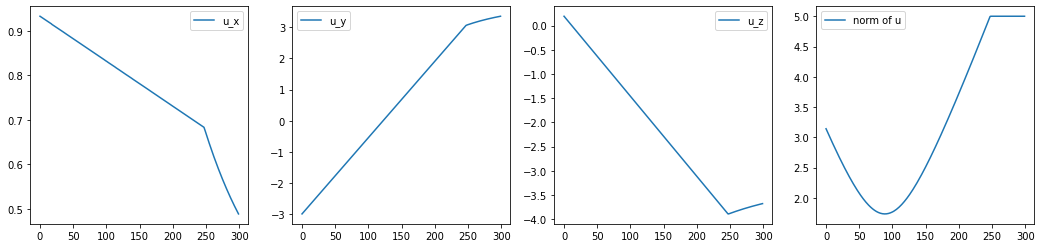

In [98]:
norm_u = np.zeros((300))

for i in range(300):
    norm_u[i] = np.linalg.norm(opt_u[3*i:3*i+3])

plt.figure(figsize=(18,4))

plt.subplot(141)
plt.plot(opt_u[0::3], label="u_x")
plt.legend()

plt.subplot(142)
plt.plot(opt_u[1::3], label="u_y")
plt.legend()

plt.subplot(143)
plt.plot(opt_u[2::3], label="u_z")
plt.legend()

plt.subplot(144)
plt.plot(norm_u[:], label="norm of u")
plt.legend()

plt.show()

In [99]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, opt_u[3*i:3*i+3]).T + g.T

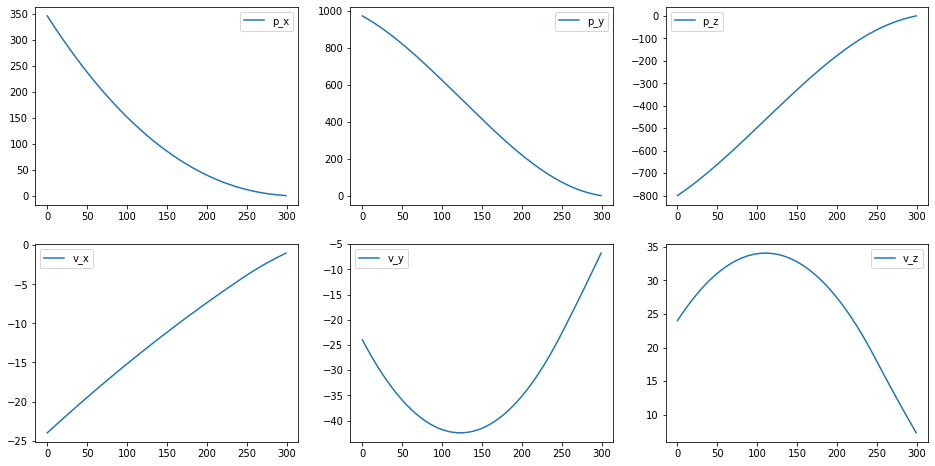

Last Point: [-0.044   0.2138 -0.0568 -1.01   -6.777   7.3227]


In [100]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

print(f"Last Point: {np.round(state[:,-1], 4)}")

# Case 2.

In [105]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([346,974,-800,-240,-240,240])

upper_boundary = 200.0
downer_boundary = 0.0

t1 = time()

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

MECS.solve() ## average run time: 0.300s

opt_u = MECS.copy_and_unpack_result()[0]

t2 = time()

## total average run time: 0.600s

print(f"runtime: {round(t2 - t1, 5)} s")

runtime: 0.26916 s


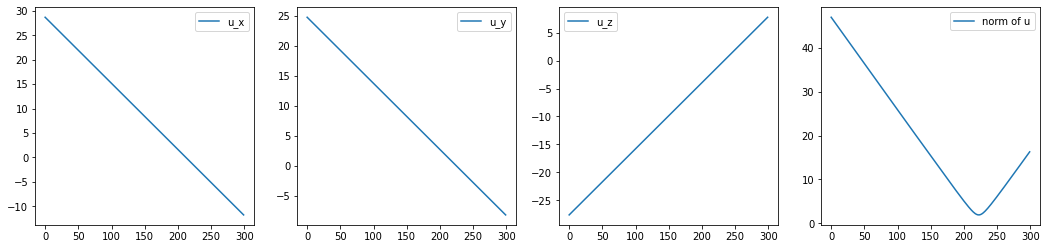

In [106]:
norm_u = np.zeros((300))

for i in range(300):
    norm_u[i] = np.linalg.norm(opt_u[3*i:3*i+3])

plt.figure(figsize=(18,4))

plt.subplot(141)
plt.plot(opt_u[0::3], label="u_x")
plt.legend()

plt.subplot(142)
plt.plot(opt_u[1::3], label="u_y")
plt.legend()

plt.subplot(143)
plt.plot(opt_u[2::3], label="u_z")
plt.legend()

plt.subplot(144)
plt.plot(norm_u[:], label="norm of u")
plt.legend()

plt.show()

In [107]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, opt_u[3*i:3*i+3]).T + g.T

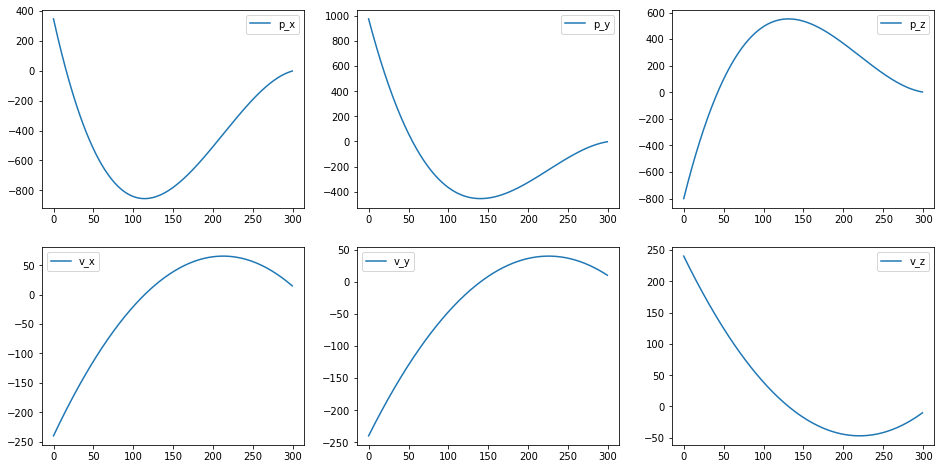

Last Point: [ -2.7107  -2.2371   2.1623  15.0239  10.42   -10.0826]


In [108]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

print(f"Last Point: {np.round(state[:,-1], 4)}")

# Case 3.

In [109]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.0
downer_boundary = 0.0

t1 = time()

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

MECS.solve() ## average run time: 0.300s

opt_u = MECS.copy_and_unpack_result()[0]

t2 = time()

## total average run time: 0.600s

print(f"runtime: {round(t2 - t1, 5)} s")

runtime: 0.22763 s


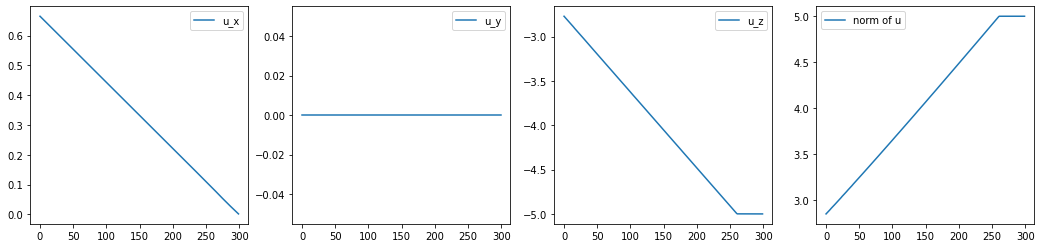

In [110]:
norm_u = np.zeros((300))

for i in range(300):
    norm_u[i] = np.linalg.norm(opt_u[3*i:3*i+3])

plt.figure(figsize=(18,4))

plt.subplot(141)
plt.plot(opt_u[0::3], label="u_x")
plt.legend()

plt.subplot(142)
plt.plot(opt_u[1::3], label="u_y")
plt.legend()

plt.subplot(143)
plt.plot(opt_u[2::3], label="u_z")
plt.legend()

plt.subplot(144)
plt.plot(norm_u[:], label="norm of u")
plt.legend()

plt.show()

In [111]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, opt_u[3*i:3*i+3]).T + g.T

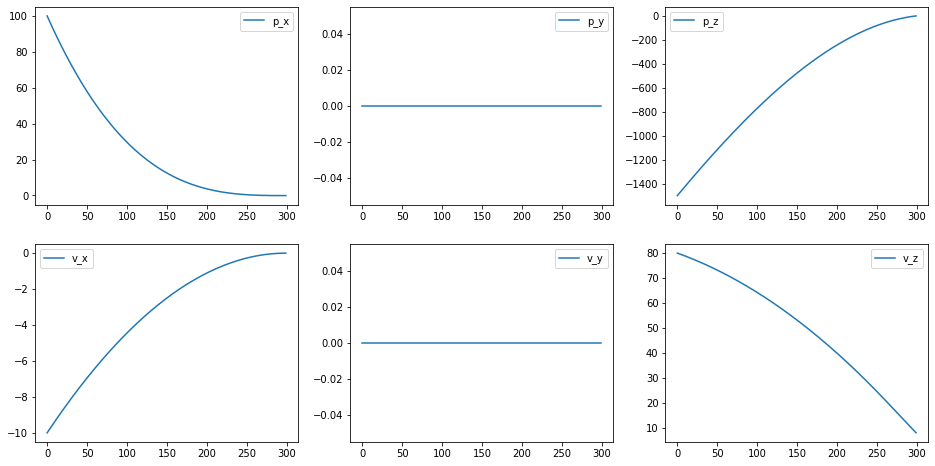

Last Point: [-1.1560e-01  0.0000e+00 -7.4780e-01 -7.6000e-03  0.0000e+00  8.1026e+00]


In [112]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

print(f"Last Point: {np.round(state[:,-1], 4)}")

# Case 4.

In [113]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([346,974,-800,-240,-240,240])

upper_boundary = 500.0
downer_boundary = 0.0

t1 = time()

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

MECS.solve() ## average run time: 0.300s

opt_u = MECS.copy_and_unpack_result()[0]

t2 = time()

## total average run time: 0.600s

print(f"runtime: {round(t2 - t1, 5)} s")

runtime: 0.27039 s


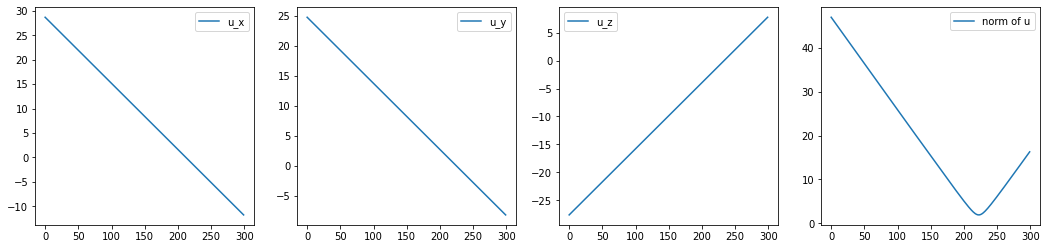

In [114]:
norm_u = np.zeros((300))

for i in range(300):
    norm_u[i] = np.linalg.norm(opt_u[3*i:3*i+3])

plt.figure(figsize=(18,4))

plt.subplot(141)
plt.plot(opt_u[0::3], label="u_x")
plt.legend()

plt.subplot(142)
plt.plot(opt_u[1::3], label="u_y")
plt.legend()

plt.subplot(143)
plt.plot(opt_u[2::3], label="u_z")
plt.legend()

plt.subplot(144)
plt.plot(norm_u[:], label="norm of u")
plt.legend()

plt.show()

In [115]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, opt_u[3*i:3*i+3]).T + g.T

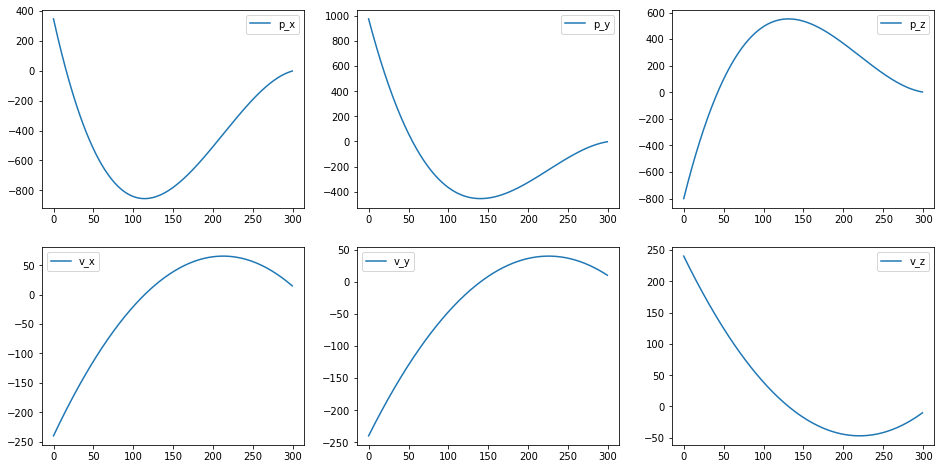

Last Point: [ -2.7107  -2.2371   2.1623  15.0239  10.42   -10.0826]


In [116]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

print(f"Last Point: {np.round(state[:,-1], 4)}")

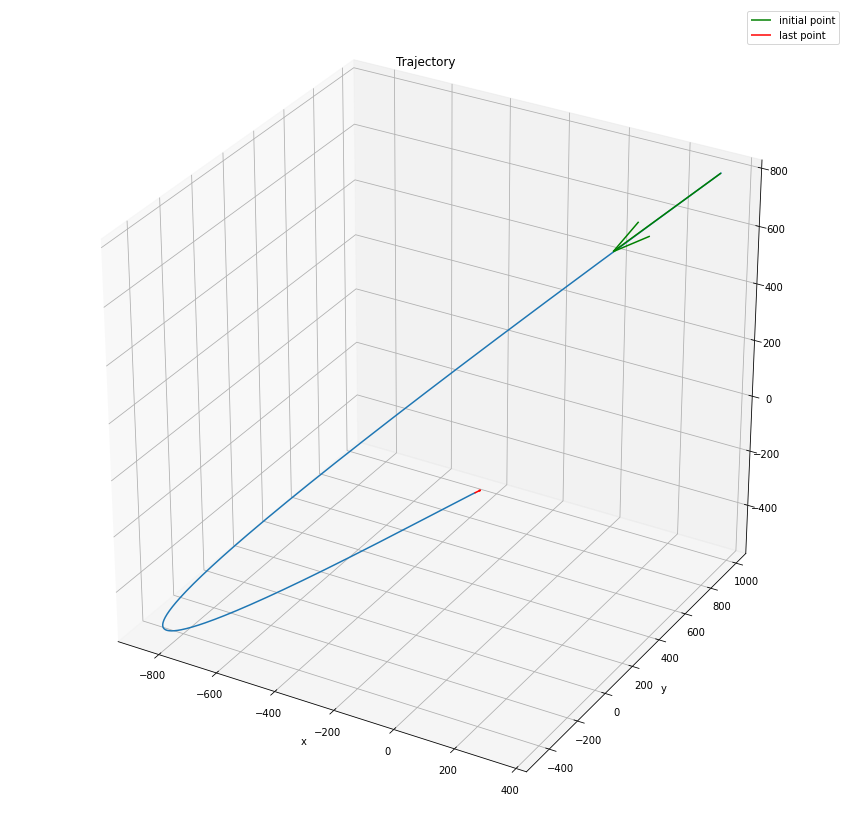

arrived at point: [-2.7107 -2.2371  2.1623]
arrived with    : [ 15.0239  10.42   -10.0826]


In [117]:
ax = plt.figure(figsize=(15,15)).add_subplot(projection="3d")

## initial point
ax.quiver(state[0,0], state[1,0], -state[2,0], state[3,0], state[4,0], -state[5,0], color="g", label="initial point")
ax.plot(state[0,:], state[1,:], -state[2,:])
ax.quiver(state[0,-1], state[1,-1], -state[2,-1], state[3,-1], state[4,-1], -state[5,-1], color="r", label="last point")

plt.title("Trajectory")
plt.xlabel("x")
plt.ylabel("y")

plt.legend()

plt.show()

print(f"arrived at point: {np.round(state[:3,-1], 4)}")
print(f"arrived with    : {np.round(state[3:,-1], 4)}")

# Test